In [1]:
import xml.etree.ElementTree as ET
import numpy
import matplotlib.pyplot
import yaml

In [2]:
def route_files() -> list:
    return {'evaluation': [
        'N1-N2-N1-N3-N1',
        'N1-N4-N1-N5-N1',
        'N1-STPL2-N1-STPL3-N1',
        'N1-CT2-N1-CT3-N1',
    ], 'training': {
        'N1-N2-N1-N3-N1',
        'N1-N4-N1-N5-N1',
        'N1-N2-N1-ST3-N1',
        'N1-CT4-N1-N5-N1',
    }}

def read_flows_with_occupancy_from_routes_file(set:str, filename: str) -> dict[str, dict]:
  filepath = '../../scenarios/breda/%s/%s/routes.0.rou.xml' % (set, filename)
  tree = ET.parse(filepath)
  root = tree.getroot()
  result = {}
  for child in root:
    assert child.tag == 'flow'
    result[child.attrib['id']] = {
      'from': child.attrib['fromJunction'],
      'to': child.attrib['toJunction'],
      'vehs': float(child.attrib['vehsPerHour']),
      'begin': int(child.attrib['begin']),
      'end': int(child.attrib['end'])
    }
  return result

def read_all_flows():
    files = route_files()
    return {set: {
        filename : read_flows_with_occupancy_from_routes_file(set, filename)
        for filename in files[set]
    } for set in files.keys()}

In [3]:
def summarize_a_single_flows(flows: dict) -> dict:
    result = {}
    for flow_id, flow_data in flows.items():
        head = flow_data['from']
        if head not in result:
            result[head] = []
        result[head] += [flow_data['vehs'] for _ in range(flow_data['begin'], flow_data['end'])]
    return {head:numpy.mean(data) for (head, data) in result.items()}

def sum_up_metric_objects(dst: dict, src: dict) -> dict:
    for key in src:
        if key not in dst:
            dst[key] = 0.0
        dst[key] += src[key]
    return src

def divide_by_metric_objects(obj: dict, delta: float) -> dict:
    for key in obj:
        obj[key] /= delta
    return obj

def summarize_flows(flows: list) -> dict:
    obj = {}
    delta = len(flows)
    for single_flows in flows:
        metrics = summarize_a_single_flows(single_flows)
        obj = sum_up_metric_objects(obj, metrics)
    obj = divide_by_metric_objects(obj, delta)
    return obj

In [4]:
def extract_valuable_metric_from_a_single_flows(flows: dict) -> dict:
    result = {}
    for flow_id, flow_data in flows.items():
        head = flow_data['from']
        if head not in result:
            result[head] = []
        result[head] += [flow_data['vehs'] for _ in range(flow_data['begin'], flow_data['end'])]
    return {
        'mean': {head:numpy.mean(data) for (head, data) in result.items()},
        'std': {head:numpy.std(data) for (head, data) in result.items()},
        'median': {head:numpy.median(data) for (head, data) in result.items()},
        'min': {head:numpy.min(data) for (head, data) in result.items()},
        'max': {head:numpy.max(data) for (head, data) in result.items()}
    }

def extract_and_arrange_data_of_multiple_flows(flowsets: dict) -> dict:
    result = {}
    for set, flows in flowsets.items():
        for flows_id, flows_data in flows.items():
            for value, directions in extract_valuable_metric_from_a_single_flows(flows_data).items():
                if (set, value) not in result:
                    result[(set, value)] = {}
                result[(set, value)][flows_id] = {'ID': flows_id, **directions}
    return result

In [5]:
def prepare_round_record_for_plot(record: dict) -> tuple[str, numpy.array, numpy.array]:
    ID = record['ID']
    Xs, Ys = [], []
    for key in record.keys():
        if key not in ['ID']:
            Xs.append(key)
            Ys.append(record[key])
    return ID, numpy.array(Xs), numpy.array(Ys)

def prepare_round_records_for_plot(records: dict) -> dict:
    result = {}
    for record in records.values():
        ID, Xs, Ys = prepare_round_record_for_plot(record)
        result[ID] = (ID, Xs, Ys)
    return result

In [6]:
def plot_diagram(round: dict, metric: str, value: str):
    metric_data = prepare_round_records_for_plot(round[(metric, value)])
    fig = matplotlib.pyplot.figure(figsize=(10, 5))
    for (ID, Xs, Ys) in metric_data.values():
        matplotlib.pyplot.plot(Xs, Ys, label=ID, marker='o')
    matplotlib.pyplot.title((metric, value))
    matplotlib.pyplot.legend()
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

In [7]:
_flows = read_all_flows()

In [8]:
_data = extract_and_arrange_data_of_multiple_flows(_flows)

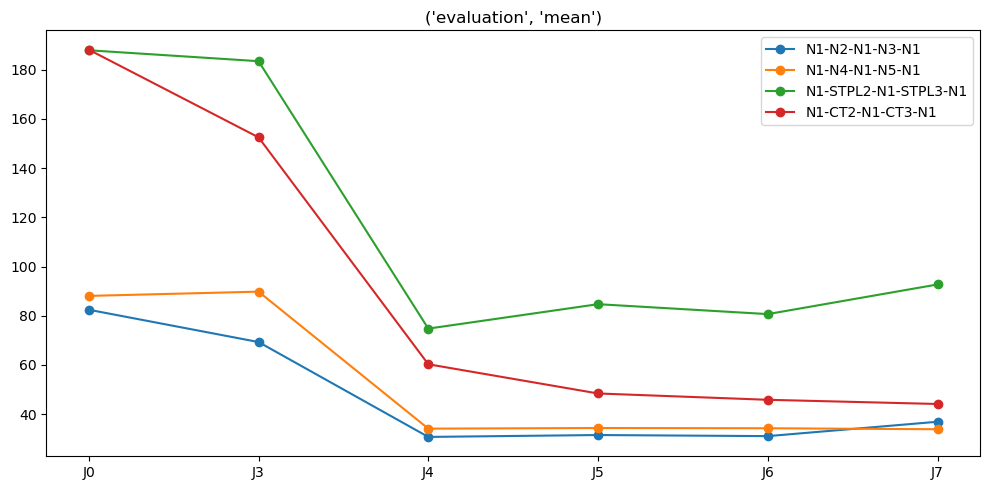

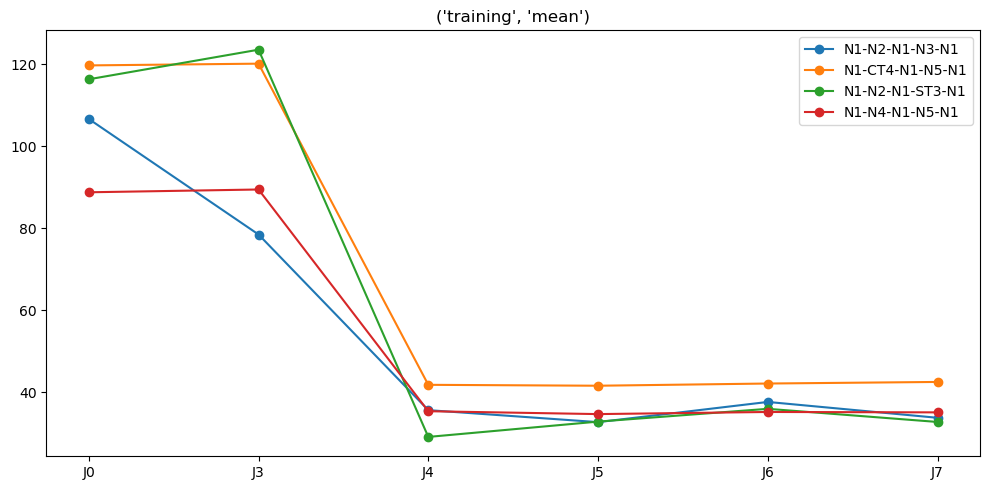

In [9]:
for (metric, value) in _data.keys():
    if value in ['mean']:
        plot_diagram(_data, metric, value)

In [10]:
def summarize_scenarios(round: dict):
    obj = {}
    for ID, data in round.items():
        for key, value in data.items():
            if key not in ['ID']:
                if key not in obj:
                    obj[key] = []
                obj[key].append(value)
    return {key:numpy.mean(value) for key,value in obj.items()}

def summarize_rounds(rounds: dict) -> dict:
    result = {}
    for (metric, value), v in _data.items():
        if metric in ['evaluation']:
            result[('occupancy', value)] = summarize_scenarios(rounds[(metric, value)])
    return result

In [11]:
with open('occupancies.yml', 'w') as file:
    yaml.dump(summarize_rounds(_data), file)